### Alex Khvatov Homework #4

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip bank+marketing.zip 
!unzip bank.zip
!rm ./bank+marketing.zip
!rm ./bank-names.txt
!rm ./bank.*
!rm ./bank-additional.zip

--2024-10-20 16:51:34--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [   <=>              ] 999.85K  2.31MB/s    in 0.4s    

2024-10-20 16:51:35 (2.31 MB/s) - ‘bank+marketing.zip’ saved [1023843]

Archive:  bank+marketing.zip
 extracting: bank.zip                
 extracting: bank-additional.zip     
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [4]:
df = pd.read_csv("bank-full.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
columns = ['age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y']

In [6]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

#df.reset_index(inplace=True)

In [7]:
categorical_columns = [c for c in categorical_columns if c in columns]
categorical_columns.remove('y')
categorical_columns

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [8]:
numeric_columns = list(df.dtypes[df.dtypes != 'object'].index)
numeric_columns = [c for c in numeric_columns if c in columns]
numeric_columns

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [9]:
#Encode target
df.y = (df.y == 'yes').astype(int)

In [10]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [11]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state=1)


## Question 1

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.

Use the training dataset for that

In [12]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


In [13]:
#use age
y_pred = df_train['age']
y_pred

14137    56
33506    33
27524    32
34058    40
25922    54
         ..
22520    32
26678    52
4964     52
20083    32
7828     38
Name: age, Length: 27126, dtype: int64

In [14]:
y_val = df_train['y']

In [15]:
results = []

for num_col in numeric_columns:
    y_pred = df_train[num_col]
    if (roc_auc_score(y_val, y_pred) < 0.5):
        y_pred = -df_train[num_col]
        
    results.append((roc_auc_score(y_val, y_pred), num_col))    
    #print(f"{num_col} -- {}")
results.sort(reverse=True)
results

[(np.float64(0.8147002759670778), 'duration'),
 (np.float64(0.5985653242764153), 'previous'),
 (np.float64(0.5901276247352144), 'pdays'),
 (np.float64(0.5888313805382317), 'balance'),
 (np.float64(0.5714543015682159), 'campaign'),
 (np.float64(0.525957882383908), 'day'),
 (np.float64(0.512185717527344), 'age')]

In [16]:
#answer 'duration'

## Question 2

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [21]:
def train(df_train, y_train):
    dicts = df_train[categorical_columns + numeric_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train=dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

    
    model.fit(X_train, y_train)
    return dv, model
    

In [30]:
def predict(df, dv, model):
    dicts = df[categorical_columns + numeric_columns].to_dict(orient = "records")
    X=dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [32]:
y_train = df_train.y.values
dv, model = train(df_train, y_train)

y_val = df_val.y.values

y_pred = predict(df_val, dv, model)
auc = roc_auc_score(y_val, y_pred)
round(auc, 3)



np.float64(0.9)

In [ ]:
#answer close to 0.89

## Question 3

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

**Precision** 
$$Precision=TP/(TP+FP)$$

**Recall** 
$$Recall=TP/(TP+FN)$$

In [44]:
#y_val from the previous step
#y_pred from the previous step




pres_recall = []

for t_int in range(0, 100):
    t = t_int/100
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    pres_recall.append((t, precision, recall))

df_pres_recall=pd.DataFrame(pres_recall, columns=['threshold', 'precision', 'recall'])

In [46]:
df_pres_recall[::10]

,threshold,precision,recall
0,0.0,0.121433,1.000000
10,0.1,0.382803,0.843352
20,0.2,0.506762,0.648452
30,0.3,0.581706,0.515483
40,0.4,0.629428,0.420765
50,0.5,0.660177,0.339709
60,0.6,0.679157,0.264117
70,0.7,0.690184,0.204918
80,0.8,0.688372,0.134791
90,0.9,0.737864,0.069217


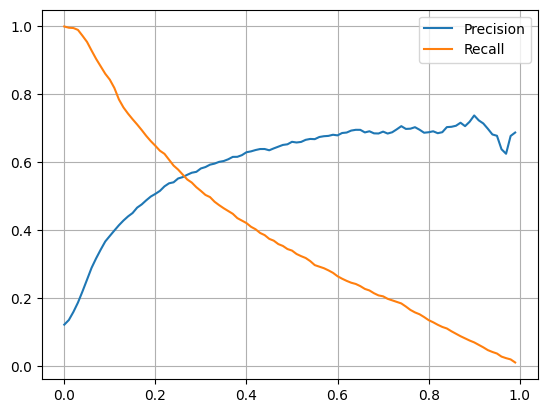

In [47]:
fix, ax = plt.subplots()
ax.plot(df_pres_recall.threshold, df_pres_recall['precision'], label='Precision')
ax.plot(df_pres_recall.threshold, df_pres_recall['recall'], label='Recall')
ax.grid()
ax.legend()

In [ ]:
#answer 0.265

## Quesiton 4
Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where 
P
 is precision and 
R
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
